In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F 
from torch import nn
import sys
import os
cwd=os.getcwd()
print(cwd)
sys.path.insert(1, cwd+'/BA_Optimization_ML/MaschineLearning/visualisation')
sys.path.insert(1, cwd+ '/BA_Optimization_ML/MaschineLearning/deeplearningModel')
import LogDataImport
import random
import matplotlib.pyplot as plt
import dataprocessing

from tqdm import tqdm
import time

    
if torch.cuda.is_available() and True:
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")    
    
torch.manual_seed(0)

/Users/leonkiesgen/Documents/Python
Running on the CPU


## Data Import

In [7]:
with tqdm(total=4) as pbar:
    #Json
    #Jsondata=json_ImExport.loadData("/Users/leonkiesgen/Documents/Python/Kappa_variation_vmax100.json")
    #Log File (Monteblanco)
    pbar.update(1)
    

    Logdata_MB=LogDataImport.get_data(cwd+"/mod_local_trajectory/logs/ltpl/2019_12_01/15_00_59_data.csv")

    #Log File (Berlin)
    pbar.update(1)
    ValLogdata_B=LogDataImport.get_data(cwd+"/mod_local_trajectory/logs/ltpl/2019_12_05/12_19_36_data.csv")

    #Log File (Modena)
    pbar.update(1)
    ValLogdata_M=LogDataImport.get_data(cwd+"/mod_local_trajectory/logs/ltpl/2019_12_05/15_41_27_data.csv")

    #Log File (zalazone)
    pbar.update(1)
    ValLogdata_Z=LogDataImport.get_data(cwd+"/mod_local_trajectory/logs/ltpl/2019_12_05/15_51_25_data.csv")


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


## Define NN Model

In [31]:
class LSTM(nn.Module):
    def __init__(self,input_size,output_size,hidden_dim,n_layers):
        super(LSTM, self).__init__()
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        self.lstm= nn.LSTM(input_size,hidden_dim,n_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self,x,hidden):

        r_out,(h,c) =self.lstm(x,hidden)
        r_out=r_out.view(-1,self.hidden_dim)
        output = self.fc(r_out)

        return output,h,c
    
    
    def zeroHidden(self):
        h0=torch.zeros(self.n_layers,1,self.hidden_dim)
        return h0

## Data Preperation

In [35]:
model=LSTM(input_size=1,output_size=1,hidden_dim=15,n_layers=1)

traindata=dataprocessing.prepareData([Logdata_MB,ValLogdata_B,ValLogdata_M,ValLogdata_Z],1)

random.shuffle(traindata)
NumSample=len(traindata)
valdata=traindata[int(NumSample*0.7):]
traindata=traindata[:int(NumSample*0.7)-1]

inputT=torch.reshape(traindata[3][1],[-1,1]).unsqueeze(0)
print(inputT.shape)


h0=model.zeroHidden()
hidden=(h0,h0)
r_out,_,_= model(inputT,(h0,h0))

print(r_out.squeeze())

70.0
0.001
torch.Size([1, 111, 1])
tensor([-0.1757, -0.1541, -0.1428, -0.1375, -0.1352, -0.1343, -0.1339, -0.1337,
        -0.1336, -0.1334, -0.1332, -0.1329, -0.1327, -0.1324, -0.1322, -0.1319,
        -0.1317, -0.1314, -0.1312, -0.1310, -0.1307, -0.1305, -0.1302, -0.1300,
        -0.1298, -0.1296, -0.1293, -0.1291, -0.1289, -0.1287, -0.1285, -0.1283,
        -0.1281, -0.1279, -0.1277, -0.1275, -0.1273, -0.1271, -0.1269, -0.1267,
        -0.1265, -0.1263, -0.1262, -0.1260, -0.1258, -0.1256, -0.1255, -0.1253,
        -0.1251, -0.1249, -0.1248, -0.1246, -0.1244, -0.1242, -0.1241, -0.1239,
        -0.1237, -0.1236, -0.1234, -0.1232, -0.1231, -0.1229, -0.1228, -0.1226,
        -0.1225, -0.1223, -0.1222, -0.1220, -0.1219, -0.1217, -0.1216, -0.1214,
        -0.1213, -0.1212, -0.1210, -0.1209, -0.1208, -0.1207, -0.1205, -0.1204,
        -0.1203, -0.1202, -0.1200, -0.1199, -0.1198, -0.1199, -0.1203, -0.1208,
        -0.1214, -0.1220, -0.1227, -0.1233, -0.1240, -0.1247, -0.1254, -0.1262,
     

In [54]:
from IPython.core.debugger import set_trace

from torch import optim
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.to(device)
num_epochs = 50

train_tracker, val_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    
    cum_loss = 0
    random.shuffle(traindata)
    
    for batch,(_, vel) in enumerate(traindata,1):
        #Prepare Input
        vel=vel.reshape([1,-1,1])
        vel=vel.to(device)
       
        h0=model.zeroHidden()
        h0=h0.to(device)
        hidden=(h0,h0)
        #Model EVAL
        output,_,_= model(vel,hidden)

        #Prepare Loss
        output=output.view(-1,1)
        output=output[:-1,0]
        outputVel=torch.reshape(vel,[-1,1])
        outputVel=outputVel[1:,0]
        outputVel=outputVel.to(device)
        #Loss EVAL
        loss = criterion(output, outputVel)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
        if batch%25==0:
            print("-",end="")

    train_tracker.append(cum_loss/len(traindata))
    
    #Validation
    test_loss = 0
    num_correct = 0
    total = 0
    
    random.shuffle(valdata)
    with torch.no_grad():
        for batch, (_, vel) in enumerate(valdata,1):
            #Prepare Input
            vel=vel.reshape([1,-1,1])
            vel=vel.to(device)
            h0=model.zeroHidden()
            h0=h0.to(device)
            hidden=(h0,h0)
            #Model EVAL
            output,_,_= model(vel,hidden)

            #Prepare Loss
            output=output.view(-1,1)
            output=output[:-1,0]
                        
            outputVel=torch.reshape(vel,[-1,1])
            outputVel=outputVel[1:,0]

            outputVel=outputVel.to(device)
            #Loss EVAL
            loss = criterion(output, outputVel)
            optimizer.zero_grad()
            test_loss += loss
            if batch%25==0:
                print(".",end="")
    val_tracker.append(test_loss/len(valdata))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(traindata)} | " ,end="")
    print(f"Val loss: {test_loss/len(valdata)} | ")

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..............................................................................Epoch(1/50) | Training loss: 0.028853526896601842 | Val loss: 0.010739997029304504 | 
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..............................................................................Epoch(2/50) | Training loss: 0.013145868118191439 | Val loss: 0.010077498853206635 | 
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..............................................................................Epoch(3/50) | Training loss: 0.01134574249894

KeyboardInterrupt: 

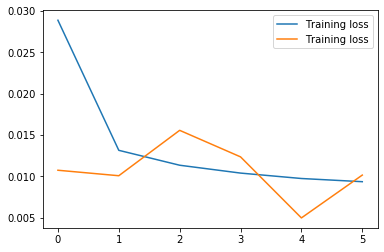

In [55]:
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(val_tracker, label='Training loss')
plt.legend()

In [56]:

from sklearn.metrics import r2_score
def Scoring(example,Score='MAE'):
    VelNormalize= Normalize(None,70)
    if Score=='MAE':
        criterion=nn.L1Loss()
    elif Score=="MSE":
        criterion=nn.MSELoss()
    elif Score=="R2":
        return
        PRED=[]
        REAL=[]
        with torch.no_grad():
            for (inp,label) in tqdm(example,leave=False):
                inp=torch.reshape(inp,[-1,1]).unsqueeze(0)
                inp=inp.to(device)
                hidden=model.zeroHidden()
                hidden=hidden.to(device)
                
                out=model(inp,hidden)

                label=label.to(device)
                out=out.squeeze()

                pred=torch.tensor(np.array(out.tolist()))
                real=torch.tensor(np.array(label.tolist()))

                PRED.append(pred.tolist())
                REAL.append(real.tolist())
        #set_trace()
        return r2_score(PRED,REAL,multioutput='variance_weighted')
    else: 
        print("Loss Function does not exist")
        return
    
    cumloss=0
    
    with torch.no_grad():
        for (inp,label) in tqdm(example,leave=False):

            inp=torch.reshape(inp,[-1,1]).unsqueeze(0)
            inp=inp.to(device)
            hidden=model.zeroHidden()
            hidden=hidden.to(device)
            out=model(inp,hidden)

            label=label.to(device)
            out=out.squeeze()

            pred=torch.tensor(VelNormalize.normal(np.array(out.tolist())))
            real=torch.tensor(VelNormalize.normal(np.array(label.tolist())))

            cumloss += criterion(pred,real)
        
    SCORE=cumloss/len(example)
    
    return SCORE.item()

In [57]:
name="LSTM_1_15_1_NEXT_STEP"
save=False
PATH= "/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/mlModels/"+ name

tensor(0.3795)
Evolived Time:  43.66588592529297 ms


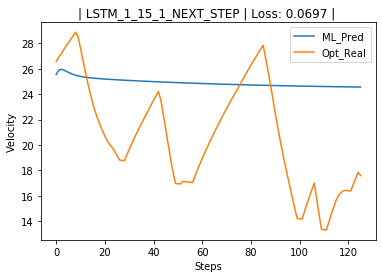

In [69]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time


def visual(x):
    #The Visualisation
    NR=x
    #Loss Functions
    criterion = nn.L1Loss()
    #criterion = nn.MSELoss()

    # Data
    testdata_inp,testdata_inp_V,testdata_lable,testdata_lable_V=[],[],[],[]
    testdata_inp=torch.clone(traindata[NR][0])
    testdata_inp_V=torch.clone(valdata[NR][0])
    testdata_lable=torch.clone(traindata[NR][1])
    testdata_lable_V=torch.clone(valdata[NR][1])
    

    t1=time.time()
    with torch.no_grad():
        pred=[]
        print(testdata_lable[0])
        v_temp=torch.reshape(testdata_lable[0],[-1,1]).unsqueeze(0)
        v_temp=v_temp.to(device)
        h=model.zeroHidden()
        c=model.zeroHidden()
        h=h.to(device)
        c=c.to(device)
        for i in range(len(testdata_inp)):
            v_temp,h,c = model(v_temp,(h,c))
            v_temp=v_temp.unsqueeze(0)
            #print(h.shape,c.shape,v_temp.shape)
            pred.append(v_temp.item())
        t2=time.time()
        print("Evolived Time: " , (t2-t1)*1000,"ms")
        testdata_lable=testdata_lable.to(device)
        loss=criterion(torch.Tensor(pred).to(device),testdata_lable)

    %matplotlib inline
    pred=70*(np.array(pred))
    real=70*(np.array(testdata_lable.tolist()))
    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")
    plt.legend(["ML_Pred","Opt_Real"])
    plt.title("| "+name + " | Loss: "+str(np.round(loss.item(),4))+""+ " | " )
    plt.xlabel("Steps")
    plt.ylabel("Velocity")
    
    
    LossEval=False
    if LossEval:
        R2Score_T=Scoring(traindata,"R2")
        print("R2_T: " ,R2Score_T)
        R2Score_V=Scoring(valdata,"R2")
        print("R2_V: " ,R2Score_V)
        
        MAEScore_T=Scoring(traindata,"MAE")
        print("MAE_T: " ,MAEScore_T)
        MAEScore_V=Scoring(valdata,"MAE")
        print("MAE_V: " ,MAEScore_V)
        
        MSEScore_T=Scoring(traindata,"MSE")
        print("MSE_T: " ,MSEScore_T)
        MSEScore_V=Scoring(valdata,"MSE")
        print("MSE_V: " ,MSEScore_V)
        
visual(165)     
#interact(visual,x=(0,len(valdata)))

## Save Model

In [37]:
#Save MODEL
if save:
    torch.save(model.state_dict(), PATH+".pt")
    torch.save(model,PATH+".pth")

C:\Users\Leon\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Leon\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
#Load MODEL with same Structure
model=LSTM(input_size=1,output_size=1,hidden_dim=15,n_layers=2)
loadPath= "/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/mlModels/BLSTM_1_15_2_Iter50_MB.pt"
model.load_state_dict(torch.load(loadPath,map_location=torch.device('cpu')))
model.eval()

LSTM(
  (lstm): LSTM(1, 15, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
  (calcH): LSTM(1, 15, num_layers=2, batch_first=True, bidirectional=True)
)

In [ ]:
#Load MODEL with different Structure
model2=torch.load(PATH+".pth")
model2.eval()

In [ ]:
model2(traindata[37][0])